#### using transfer learning for the segementation job

In [8]:
import tensorflow as tf

print(tf.__version__)
print(tf.__file__)

2.8.0
E:\INSTALL\anaconda\envs\LM\lib\site-packages\tensorflow\__init__.py


In [9]:
# check the status of GPU
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()

[print(x) for x in local_device_protos if x.device_type == 'GPU']

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5730467840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5302970762529414870
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419



[None]

define the neptune for documenting

In [10]:
# define if the documenting process should go on

DOCUMENT = False
TRAIN = 50  # training epochs num


In [11]:
# neptune document

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

if DOCUMENT:

    run = neptune.init(
        project="leeleeroy/LM-2D-Unet",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjVjOGVmZi04MjA4LTQ4N2QtOWIzYy05M2YyZWI1NzY3MmEifQ==",
        name = "UNet2D_64_vgg16",
    ) # necessary credentials, the name could be used to reproduce the results 

    # for callbacks in training



    neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics')  # neptune for the training process
    
    # neptune document the hyper param.

    PARAMS = {
              "optimizer": {"learning_rate": 0.001, "beta_1":0.9,"optimizer": "Adam"},
              'epochs': TRAIN,
              'batch_size':8}

    # log hyper-parameters
    run['hyper-parameters'] = PARAMS
    run["sys/tags"].add(["transfer", "vgg16", "val", "test", "epochs:50"])


In [12]:
# data loading 

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import os
import pandas as pd
import random

#### Load data in

In [13]:
# PATH = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_partial/'
PATH = 'F:/Data/MLID/LM/fMax_zebrafish/noPad/final/'  # local machine

Mask = np.load(PATH + 'fMax.npy')
Mask = Mask.reshape(-1,1040, 1392)
IMG = np.load(PATH + 'rawIMG.npy')
IMG = IMG.reshape(-1, 1040, 1392)

print('Mask shape: ', Mask.shape)
print('Image shape: ', IMG.shape)

Mask shape:  (380, 1040, 1392)
Image shape:  (380, 1040, 1392)


In [14]:
# visualization for two images

def subShow(IMG1, IMG2):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(IMG1, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(IMG2, cmap='gray')
    plt.show()

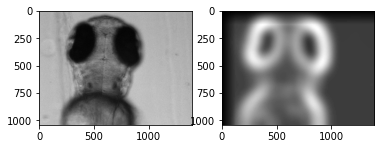

In [15]:
# sanity check for the two dataset in original size

subShow(IMG[0,...], Mask[0,...])

In [16]:
# patchify the images

def rawPatch(imageStack,patchPara):
    all_img_patches = []

    for img in range(imageStack.shape[0]):
        large_image = imageStack[img]

        patches_img = patchify(large_image, (patchPara['x'],patchPara['y']), step=patchPara['step'])  # no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                # transform the image if the type is not correct
                if single_patch_img.dtype == 'uint8':
                    single_patch_img = (single_patch_img.astype('float32')) / 255.  # remember to standarize into 0-1
                    
                all_img_patches.append(single_patch_img)
    
    return all_img_patches, patches_img.shape

In [17]:
# due to the huge data amount, use part of the images for the training 
# resize the images for later patchify
from skimage.transform import resize

size = [256*(IMG.shape[1]//256), 256*(IMG.shape[2]//256)]
numIMG = 30
smallIMG = resize(IMG[:numIMG,...], (numIMG,size[0],size[1]), anti_aliasing=True)
smallMask = resize(Mask[:numIMG,...], (numIMG,size[0],size[1]), anti_aliasing=True)

In [18]:
# prepare the test dataset
NUM1 = 51
NUM2 = 55

testIMG = resize(IMG[NUM1:NUM2,...], (NUM2-NUM1,size[0],size[1]), anti_aliasing=True)
testMask = resize(Mask[NUM1:NUM2,...], (NUM2-NUM1,size[0],size[1]), anti_aliasing=True)

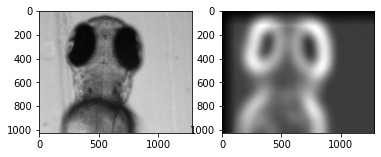

img: (30, 1024, 1280) float64
mask: (30, 1024, 1280) float64
img range: 0.3625603170955914 0.0
mask range: 0.8549019607843137 0.0


In [19]:
# sanity check for the resized data

subShow(smallIMG[0,...], smallMask[0,...])

print('img:',smallIMG.shape, smallIMG.dtype)
print('mask:',smallMask.shape, smallMask.dtype)

print('img range:', np.max(smallIMG), np.min(smallIMG))
print('mask range:', np.max(smallMask), np.min(smallMask))

In [20]:
# preporcessing the data

from patchify import patchify, unpatchify


# train dataset
THRESHOLD = 0.2
patchPara = {'x': 256, 'y': 256, 'step':256}

X_patches, _ =  rawPatch(smallIMG, patchPara); X_patches = np.stack((X_patches,)*3, axis=-1)
Y_masks, _ = rawPatch(smallMask, patchPara); Y_masks = np.expand_dims(Y_masks, -1)


In [21]:
print('patches shape:',X_patches.shape, X_patches.dtype)
print('mask shape:',Y_masks.shape, Y_masks.dtype)
print(np.max(Y_masks[0,...]), np.min(Y_masks[0,...]))
print(np.max(X_patches[0,...]), np.min(X_patches[0,...]))

patches shape: (600, 256, 256, 3) float64
mask shape: (600, 256, 256, 1) float64
0.3176470588235294 0.0
0.16724034926470593 0.04524509803921533


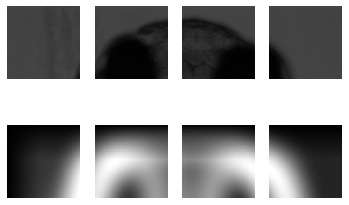

In [22]:
#  sanity check for the mask and images

IMG_test = X_patches
GT_test = Y_masks

startNum = 100
n_samples = 4

for i in range(n_samples):
    plt.subplot(2, n_samples, 1+i)
    plt.axis('off')
    plt.imshow(IMG_test[int(i+startNum)], cmap='gray')
    
for i in range(n_samples):
    plt.subplot(2, n_samples, 1+n_samples+i)
    plt.axis('off')
    plt.imshow(GT_test[int(i+startNum)], cmap='gray')    
plt.show()


#### prepare the models

In [23]:
# usinng pre-trained weight

import tensorflow
import tensorflow.keras

import segmentation_models as sm

# from keras_applications.resnet import ResNetV2

BACKBONE = 'resnet34'  # different backbone is offered here
preprocess_input = sm.get_preprocessing(BACKBONE)

Segmentation Models: using `keras` framework.


In [24]:
# preprocessing the data

# preprocess input
images = X_patches; masks = Y_masks;
images = preprocess_input(images)
# print(images1.shape)  # come with packed toolset

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(images, masks, test_size = 0.25, random_state = 42)

In [25]:
print('training data:', X_train.shape, Y_train.shape)
print('validation data:', X_val.shape, Y_val.shape )

training data: (450, 256, 256, 3) (450, 256, 256, 1)
validation data: (150, 256, 256, 3) (150, 256, 256, 1)


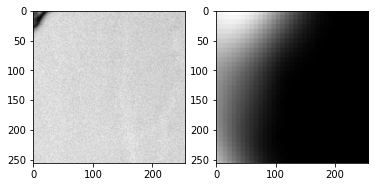

In [26]:
#Sanity check for training dataset. view few mages

import random
import numpy as np
image_number = random.randint(0, len(X_train))

subShow(X_train[image_number, :,:, 0], Y_train[image_number])

# plt.figure(figsize=(12, 6))
# plt.subplot(121)
# plt.imshow(X_train[image_number, :,:, 0], cmap='gray')
# plt.subplot(122)
# plt.imshow(np.reshape(Y_train[image_number], (256, 256)), cmap='gray')
# plt.show()

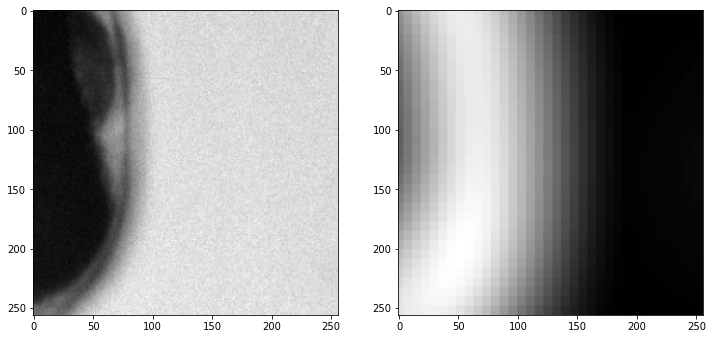

In [27]:
#Sanity check for testing dataset, view few mages

image_number = random.randint(0, len(X_val))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_val[image_number, :,:, 0], cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(Y_val[image_number], (256, 256)), cmap='gray')
plt.show()

In [28]:
# data generator

seed=24
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# add data augmentaton strategy
img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',)
                     #preprocessing_function = lambda x: np.where(x>0.1, 1, 0).astype(x.dtype)) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)  # relevant to normalization

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_val, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(Y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(Y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(Y_val, seed=seed)

In [29]:
# pack the two generators together

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

In [30]:
# generator pack for later use
my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

x = image_generator.next()
y = mask_generator.next()

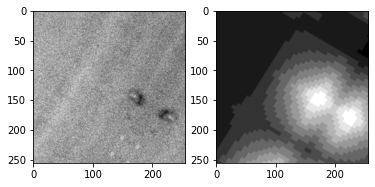

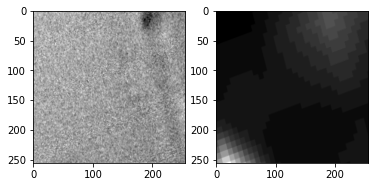

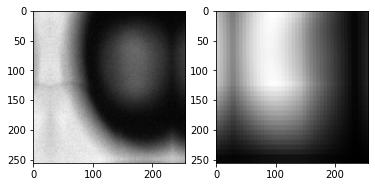

In [31]:
# sanity check in the generator size 0-31

for i in range(28,31):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0], cmap='gray')
    plt.show()

In [32]:
# define model
import segmentation_models as sm

sm.set_framework('tf.keras')  # try this if the sm is problematic
sm.framework()

model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])  # bce is differentiable
# print(model.summary())

In [34]:
#Fit the model and train

import tensorflow.keras as k

callbacks = [
    #k.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    k.callbacks.TensorBoard(log_dir = './Unet/tensorBoard')
]

history = model.fit_generator(my_generator, validation_data=validation_datagen, steps_per_epoch=50, validation_steps=50, epochs=TRAIN, callbacks = callbacks)

E:\INSTALL\anaconda\envs\LM\lib\site-packages\ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/50
50/50 [==============================] - 55s 833ms/step - loss: 1.3064 - iou_score: 0.2568 - val_loss: 3.8604 - val_iou_score: 0.2487
Epoch 2/50
50/50 [==============================] - 37s 746ms/step - loss: 1.2887 - iou_score: 0.2569 - val_loss: 136.8379 - val_iou_score: 0.2653
Epoch 3/50
50/50 [==============================] - 37s 745ms/step - loss: 1.2936 - iou_score: 0.2538 - val_loss: 24.5443 - val_iou_score: 0.2625
Epoch 4/50
50/50 [==============================] - 37s 749ms/step - loss: 1.2893 - iou_score: 0.2521 - val_loss: 2.5484 - val_iou_score: 0.2521
Epoch 5/50
50/50 [==============================] - 38s 773ms/step - loss: 1.2811 - iou_score: 0.2658 - val_loss: 1.4242 - val_iou_score: 0.1550
Epoch 6/50
50/50 [==============================] - 37s 756ms/step - loss: 1.2820 - iou_score: 0.2616 - val_loss: 1.4356 - val_iou_score: 0.1462
Epoch 7/50
50/50 [==============================] - 38s 777ms/step - loss: 1.2825 - iou_score: 0.2599 - val_loss: 1.4996 - val_

KeyboardInterrupt: 

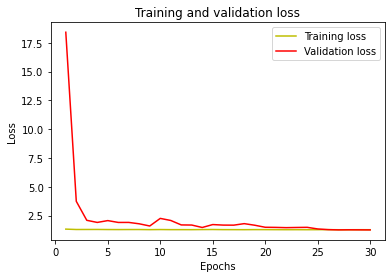

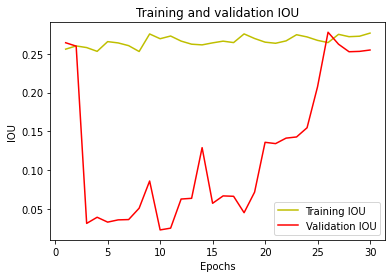

In [27]:
#plot the training and validation accuracy and loss at each epoch

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss.png')

# iou
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.figure()
plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()
plt.savefig('loss.png')


In [28]:
# save model as local

model.save("./Unet/model/Unet2D_transfer_resnet.h5")

#### test dataset

In [29]:
# # prepare the test dataset
NUM1 = 51
NUM2 = 57

testIMG = resize(IMG[NUM1:NUM2,...], (NUM2-NUM1,size[0],size[1]), anti_aliasing=True) # only takes 5 images from the raw databank
testMask = resize(Mask[NUM1:NUM2,...], (NUM2-NUM1,size[0],size[1]), anti_aliasing=True)

unpatchPara = testIMG[0].shape

In [ ]:
# X_test, _ =  rawPatch(testIMG, patchPara)
# X_test = np.stack((X_test,)*3, axis=-1)
# X_test = preprocess_input(X_test)


# Y_test, _ = rawPatch(testMask, patchPara)
# Y_test = np.expand_dims(Y_test, -1)


In [30]:
# test on bigger image
from patchify import patchify, unpatchify

imagePred = []

for i in range(testIMG.shape[0]):
    tIMG = np.expand_dims(testIMG[i,...], axis=0)
    tPatch, _ = rawPatch(tIMG, patchPara)
    tPatch = np.stack((tPatch,)*3, axis=-1)
    tPatch = preprocess_input(tPatch)
    tPred = model.predict(tPatch)
    imgPred = np.reshape(tPred[...,0], (4, 5, 256, 256))
    imgPred = unpatchify(imgPred, unpatchPara)
    imagePred.append(imgPred)
    
imagePred = np.asarray(imagePred)

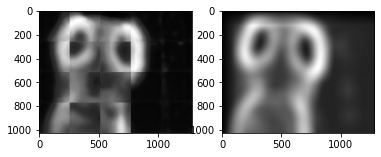

In [31]:
subShow(imagePred[0,...], testMask[0,...])

In [ ]:
# # calculate the IOU score
# Y_pred = model.predict(X_test) 
# y_pred_thresholded = Y_pred > THRESHOLD

# intersection = np.logical_and((Y_test > THRESHOLD), y_pred_thresholded)  # calculate IOU requires binary
# union = np.logical_or(Y_test, y_pred_thresholded)
# iou_score = np.sum(intersection) / np.sum(union)
# print("IoU socre is: ", iou_score)

In [ ]:
# images = preprocess_input(images)

# # prediction IOU

# #IOU
# y_pred=model.predict(X_test)  # get test images
# y_pred_thresholded = y_pred > 0.5

# intersection = np.logical_and((Y_test > 0.5), y_pred_thresholded)  # calculate IOU requires binary
# union = np.logical_or(Y_test, y_pred_thresholded)
# iou_score = np.sum(intersection) / np.sum(union)
# print("IoU socre is: ", iou_score)

In [ ]:
# sanity check

# test = y_pred[127,...]
# test2 = Y_test[127,...]
# print(test.shape)
# plt.subplot(1,2,1)
# plt.imshow(test,cmap='gray')
# plt.axis('off')

# plt.subplot(1,2,2)
# plt.imshow(test2,cmap='gray')
# plt.axis('off')
# plt.show()

In [ ]:
# test3 = (test*255).astype('uint8')
# plt.imshow(test3, cmap='gray')

In [ ]:
# visualization

# test_img_number = random.randint(0, len(X_test)-1)
# test_img = X_test[test_img_number]  # for test
# test_img_input=np.expand_dims(test_img, 0)
# ground_truth=Y_test[test_img_number]  # GT for the test
# prediction = model.predict(test_img_input)  # prediction
# prediction = prediction[0,:,:,0]

# plt.figure(figsize=(16, 8))
# plt.subplot(231)
# plt.title('Testing Image')
# plt.imshow(test_img[:,:,0], cmap='gray')
# plt.subplot(232)
# plt.title('Testing Label')
# plt.imshow(ground_truth[:,:,0], cmap='gray')
# plt.subplot(233)
# plt.title('Prediction on test image')
# plt.imshow(prediction, cmap='gray')

# plt.show()


In [ ]:
# save model as local

# model.save("./transfer/model/Unet2D_transfer_resnet.h5")

In [ ]:
# # save iamges as local
# np.save("./transfer/IMG/transPred.npy", y_pred)
# np.save("./transfer/IMG/transGT.npy", Y_test)


In [ ]:
# # resume to logging more data
# import neptune.new as neptune

# run = neptune.init(
#     project='leeleeroy/UNet-2D-EM',
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjVjOGVmZi04MjA4LTQ4N2QtOWIzYy05M2YyZWI1NzY3MmEifQ==",
#     run="UN-39",  
# )  # necessary credentials, the name could be used to reproduce the results 

# neptune.create_experiment(upload_source_files=['Unet_transfer.ipynb'])

In [ ]:
# # neptune for showing the test images
# # run = neptune.init(project="leeleeroy/UNet-2D-EM", run="UN-39")  # resume the documentation

# for i in range(y_pred.shape[0]):
#     predTemp = y_pred[i]
#     predTemp = np.interp(predTemp, (predTemp.min(), predTemp.max()), (0, 1))  # neptune only receives 0-1
#     GTTemp = Y_test[i]
#     GTTemp = np.interp(GTTemp, (GTTemp.min(), GTTemp.max()), (0, 1))
#     bar = np.zeros((y_pred[i].shape[0], 15))
#     combTemp = np.concatenate((np.squeeze(predTemp),bar,np.squeeze(GTTemp)), axis=1)
#     run["test/sample_images"].log(neptune.types.File.as_image(combTemp), name=str(i), description='test images from 3rd stack')  # upload the test results into neptune. could also add 'description'

In [ ]:
# run.stop()  # remember to stop the neptune